# AI Poetry Generation (GPT-2)

This notebook uses a finetuned AI model (GPT-2 medium: 355M) to generate poetry. The generation interface is served as a Flask webapp with the help of an Ngrok utility library. The model has been finetuned on corpuses of traditional poetry (gleaned from [PoetryDB](https://poetrydb.org)) and some more contemporary poetry (taken from [here](https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset)), which means that it is optimised for poetry generation.

You can have a look at [some of the examples generated](http://thecombedthunderclap.blogspot.com/2020/10/gpt-2-poetry.html).

For best results run the notebook in Google Colab using a GPU runtime. The GPU speeds up text generation, and Google Colab offers free GPU usage. If you are not running on Colab, but would like to, [this link](https://colab.research.google.com/github/thunderclapinteractive/poetrywtf-nlp/blob/master/notebooks/generate_gpt_2_poetry.ipynb.) should open the Notebook in your personal Colab environment (assuming you have a Google account).

*Credit:* The model was finetuned using Max Woolf's [gpt-2-simple](https://github.com/minimaxir/gpt-2-simple) library, which is also used for the text generation. If you are interested in AI text generation you should definitely check out [Max's work](https://minimaxir.com/).


## Install and import libraries

In [ ]:
!pip install gpt_2_simple
!pip install tensorflow==1.15
!pip install flask-ngrok
!pip install flask==0.12.2

In [ ]:
import gpt_2_simple as gpt2
import tensorflow as tf
import sys
import os

from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok

print("Available GPUs: ", tf.config.experimental.list_physical_devices('GPU'))
print()

!nvidia-smi

## Set global variables

In [3]:
n_samples = 3
length = 250
temperature = 1.0
top_k = 1000
top_p = 0.95
prefix = "I wandered lonely as a toad"

drive_path = '/content/drive'
share_path = f"{drive_path}/My Drive/poetrygen"

run_name = "latest"

model_dir = f"{share_path}/models/gpt-2-simple/"
checkpoint_dir = f"{model_dir}/checkpoint/"
run_dir = f"{checkpoint_dir}{run_name}/"

flask_template_dir = f"{share_path}/flask/templates/"


## Create shortcut to Shared Drive

The model's files are being shared from a Google Drive. To allow the notebook to load the files the simplest way is to create a shortcut by going directly to the Shared folder URL: 

https://drive.google.com/drive/folders/1duOgXb37uLuOZ4A-HNfYLeNsUeafWlMz

Then right-click on the folder and create a shortcut:

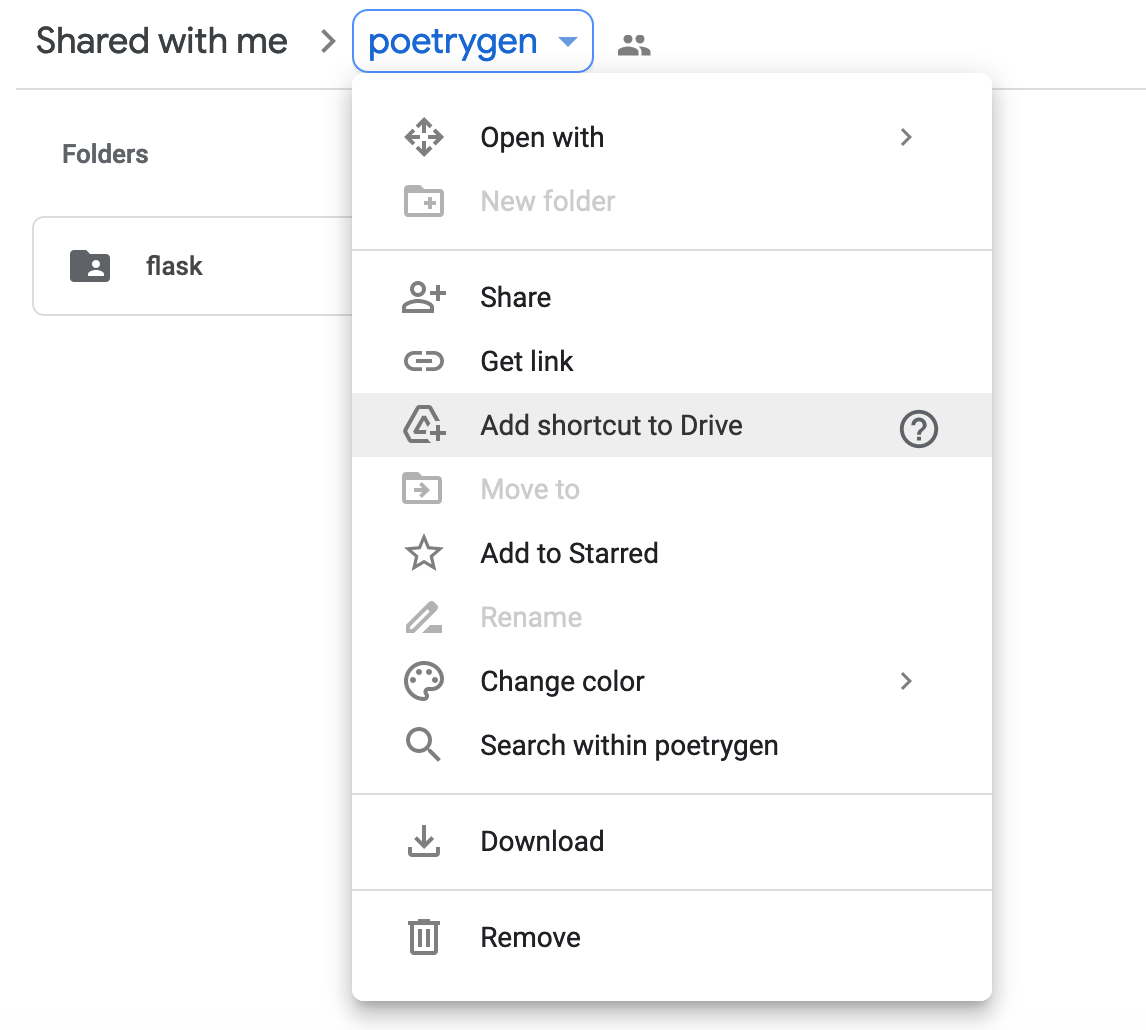

Then add the shortcut to your Google Drive:

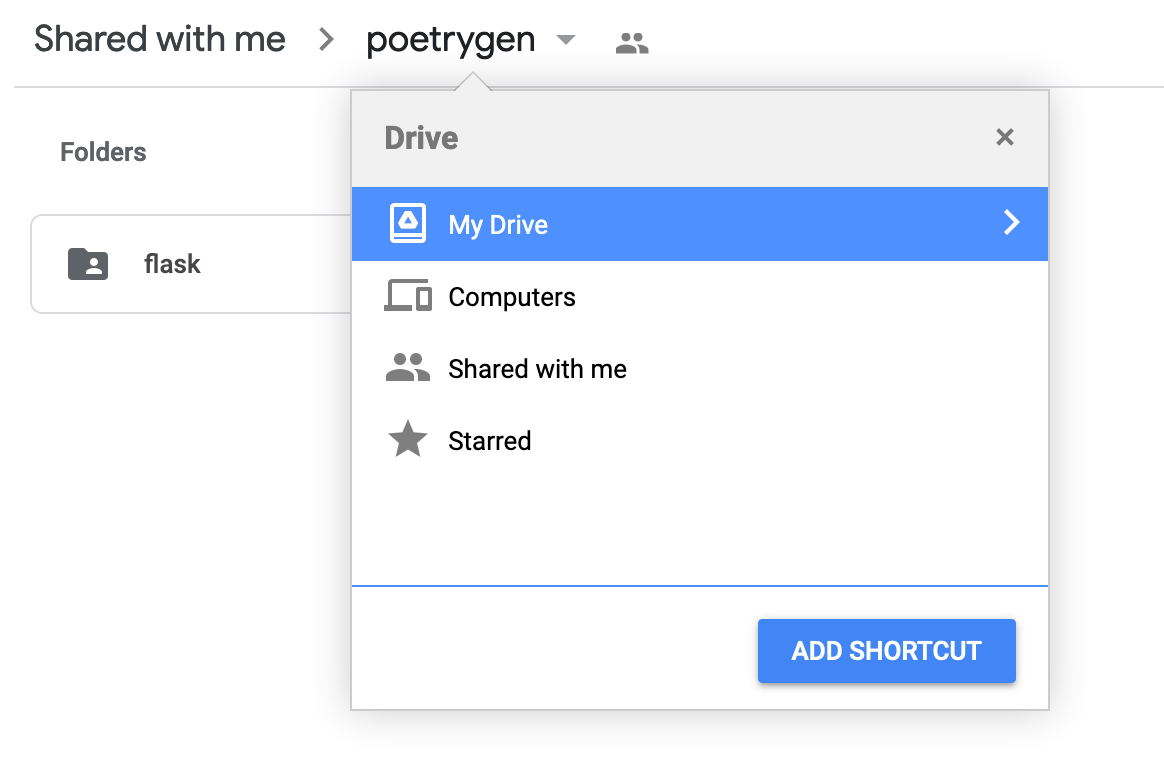

The shared folder shortcut should then be visible in your Google Drive directory tree:

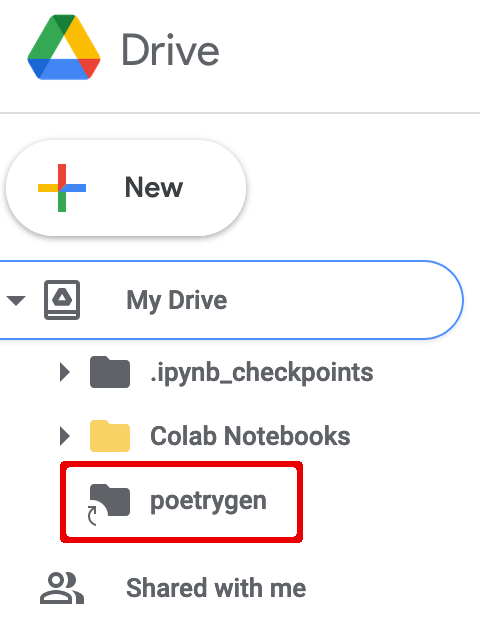

## Mount Google Drive

This step uses your Google credentials to mount your Google Drive so that the shortcut created in the previous step can be accessed by the notebook. 

Run the cell and follow the instructions: Click on the URL link, select your Google account, click Allow, copy the auth code, paste it into the provided box and press enter to continue.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load checkpoint

Start a tensorflow (gpt-2-simple) session.

In [ ]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess,
               run_name=run_name,
               checkpoint_dir=checkpoint_dir,
               model_dir=model_dir)

## Create Flask app

Create a Flask app that will use Ngrok at runtime.

[Ngrok](https://github.com/gstaff/flask-ngrok) offers a handy way to access the UI of an app run in Colab, which can make for a more convenient experience than the native Notebook interface. It is also possible to share an Ngrok link with another user.

In [6]:
template_dir = os.path.abspath(flask_template_dir)
app = Flask(__name__, template_folder=template_dir)
run_with_ngrok(app)

## Define route

The Flask app home route ("/") takes input from the template UI (the prompt, and the various parameters), and then generates the text based on that. The generated poetry is provided back to the template and displayed in the browser UI.

In [7]:
@app.route('/', methods=['GET', 'POST'])
def home():
    # Set global vars
    global sess, prefix, n_samples, length, temperature, top_k, top_p

    # Clear relevant vars
    text = []
    new_text = ""
    new_text_array = []
    user_input = ""

    if request.method == 'POST':
        # Get user input and create prefix
        form_input = request.form

        prefix = f"{form_input.get('prompt')}"
        n_samples = int(form_input.get('n_samples'))
        length = int(form_input.get('length'))
        temperature = float(form_input.get('temperature'))
        top_k = int(form_input.get('top_k'))
        top_p = float(form_input.get('top_p'))

        # Generate text
        text = gpt2.generate(sess,
                             checkpoint_dir=checkpoint_dir,
                             model_dir=model_dir,
                             run_name=run_name,
                             prefix=prefix,
                             batch_size=n_samples,
                             nsamples=n_samples,
                             return_as_list=True,
                             length=length,
                             temperature=temperature,
                             top_k=top_k,
                             top_p=top_p,
                             include_prefix=True)

        # Format output
        for i, sample in enumerate(text):
          new_text = f"{new_text}Sample {i+1} :\n\n{sample}\n\n"
          
        new_text = new_text.replace("\n", "</br>")

    default_prompt = prefix
    prefix = prefix.replace("\n","</br>")

    return render_template('index.html', 
                           new_text=new_text, 
                           default_prompt=default_prompt, 
                           prefix=prefix, 
                           n_samples=n_samples, 
                           length=length, 
                           temperature=temperature, 
                           top_k=top_k, 
                           top_p=top_p)


## Run app

The Flask app is run and made available via an [Ngrok](https://ngrok.com/) URL. Click on the ngrok URL and this will bring up the app UI in the browser.



In [ ]:
if __name__ == "__main__":
    app.run()

## Generate poetry

You will now be able to:

### Add a prompt

The prompt is used as a way to guide the model regarding the kind of language you want in your text generation. As the finetuned model is optimised for poetry, it is best to provide poetry of some kind, however it appears prose instructions can help too. See [this post](https://) for examples.

### Set sample number

You can adjust the number of samples you want to generate. As the process is largely parallelised it is an efficient way to generate multiple samples. Recommended.

### Set length

The length of a single sample's output can be set up to a maximum of 1024 characters. The longer the output, the longer it takes to generate.

### Set temperature

The temperature is also called perplexity. This is essentially a way to constrain the generated output at lower values (eg. 0.5-0.7 range) or give it more freedom and creativity at higher values (eg. 1.0+). At higher values the risk is that the output becomes too random and lacks coherence, whereas if it is too constrained then the language can lack creative interest. The finetuned model appears to work well in the 0.9-1.0 range, but it's always useful to experiment.

### Set top K

The AI typically selects the most likely next word (k=1) as output. However we might like to give the top k number of words a chance by redistributing the probability mass among them. [This is what the top K setting does](https://huggingface.co/blog/how-to-generate#top-k-sampling). The value is set to 1000 by default. It is best to experiment a bit by adjusting the value. There is a potential trade off with top P (see below), in which case one or the other can be set to 0 to disable it.

### Set top P

As with top K, top P is an attempt to change the way the AI selects the next word. This time [the cumulative probability is more important](https://huggingface.co/blog/how-to-generate#top-k-sampling) than the number of words. It is set to 0.9 by default, but as with top K it is best to experiment. To disable top P, set it to 0.

### Generate text

When you are happy with all the settings, click on the generate button and wait for the poetry to be generated. Depending on the type of GPU it can take 5 seconds or more per 100 characters.